In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [ ]:
pip install odc-geo --quiet

In [26]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import datacube
import rioxarray
import odc.geo.xr
import matplotlib.pyplot as plt
from rasterio.features import sieve
from odc.algo import mask_cleanup
import numpy as np

from intertidal.validation import eval_metrics, map_raster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# Load Wollogorang data
intertidal_ds = rioxarray.open_rasterio('data/raw/intertidal_dem_s2ls_gca_Wollogorang.tif', masked=True).squeeze('band')
lidar_ds = rioxarray.open_rasterio('data/raw/lidar_Wollogorang.tif', masked=True).squeeze('band')

# # Load Greenbank data
# intertidal_ds = rioxarray.open_rasterio('data/raw/intertidal_dem_s2ls_gca_Greenbank.tif', masked=True).squeeze('band')
# lidar_ds = rioxarray.open_rasterio('data/raw/lidar_Greenbank.tif', masked=True).squeeze('band')

In [44]:
# Restrict data to large areas of intertidal (experimental)
large_mask = sieve(source=(~intertidal_ds.isnull()).astype(np.int16).values, size=500)
intertidal_ds = intertidal_ds.where(large_mask)
map_raster(intertidal_ds)


In [8]:
# Analyse only pixels that contain valid data in both after removing 
# always-wet pixels from LiDAR data
invalid_data = intertidal_ds.isnull() | lidar_ds.isnull() | (lidar_ds < (lidar_ds.min() + 0.01)) 
lidar_z = lidar_ds.values[~invalid_data.values]
intertidal_z = intertidal_ds.values[~invalid_data.values]

Correlation         0.760
RMSE                0.194
MAE                 0.142
R-squared           0.332
Regression slope    0.777
dtype: float64

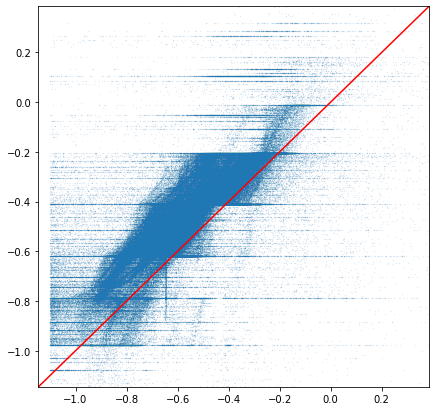

In [45]:
# Plot and compare
plt.figure(figsize=(7, 7))
plt.scatter(x=lidar_z, y=intertidal_z, s=0.01, alpha=0.5)
lim_min, lim_max = np.percentile(np.concatenate([lidar_z, intertidal_z]), [1, 99])
plt.xlim(lim_min - 0.1, lim_max + 0.1)
plt.ylim(lim_min - 0.1, lim_max + 0.1)
plt.plot([lim_min - 0.1, lim_max + 0.1], [lim_min - 0.1, lim_max + 0.1], c='red')
eval_metrics(x=lidar_z, y=intertidal_z, round=3)